<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/main/KNN_16QAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Generación y modulación

In [ ]:
Ns= 10000
Mod=16 #16QAM
Symbols_tx = np.random.randint(Mod, size=Ns)
df_sym_tx= pd.DataFrame(Symbols_tx)
print(Symbols_tx[0:10])

[ 5 13  5  1 15 14 14 15  5  4]


In [ ]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j, #1000
            9:3+1j, #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [ ]:
#Modulación reemplazando símbolos por valores complejos - mapeo (opción 2)
df_sym_mod2 = df_sym_tx.iloc[:,0].map(mod_dict)
df_sym_mod2.head(20)

0    -1.0+1.0j
1     1.0+1.0j
2    -1.0+1.0j
3    -3.0+1.0j
4     1.0-1.0j
5     1.0-3.0j
6     1.0-3.0j
7     1.0-1.0j
8    -1.0+1.0j
9    -1.0+3.0j
10   -3.0+1.0j
11   -3.0+1.0j
12    3.0-1.0j
13   -3.0-3.0j
14   -1.0-1.0j
15    3.0+3.0j
16    3.0-1.0j
17    3.0+1.0j
18    1.0-1.0j
19    1.0-1.0j
Name: 0, dtype: complex128

# Transmisión canal AWGN

In [ ]:
Xr = np.real(df_sym_mod2)
Xi = np.imag(df_sym_mod2)

In [ ]:
# Adición de ruido blanco Gaussiano (AWGN)

target_snr_db = 16
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)
#print(Xr_avg_db)
noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
#print(Xi_avg_db)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
Xi_ch = Xi + noise_i

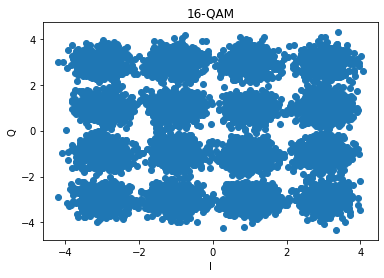

In [ ]:
plt.plot(Xi_ch, Xr_ch, 'o')
plt.xlabel('I')
plt.ylabel('Q')
plt.title('16-QAM')
plt.show()

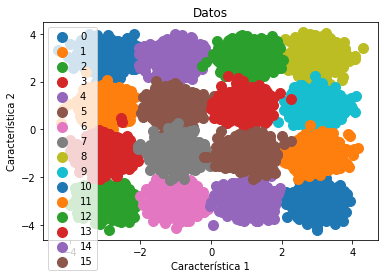

In [ ]:
fig, ax = plt.subplots()
for g in np.unique(Symbols_tx):
    ix = np.where(Symbols_tx == g)
    ax.scatter(Xr_ch[ix], Xi_ch[ix], label = g, s = 100)
ax.legend()
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Datos')
plt.show()

# Demodulación

In [ ]:
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return(symbol)

In [ ]:
sym_rx= demapper_sym(Xr_ch, Xi_ch, len(Xr_ch), threshold = 2.0)
print(sym_rx[0:10])

[5, 13, 5, 1, 15, 14, 14, 15, 5, 4]


In [ ]:
def SER_f(sym_rx, Symbols_tx, Ns):
    error = 0
    for i in range(Ns):
        if sym_rx[i] == Symbols_tx[i]:
            error = error
        else:
            error= error + 1
    SER = error/Ns
    return([SER, error])

In [ ]:
SER, error = SER_f(sym_rx, Symbols_tx, Ns)
print(SER)
print(error)

0.0071
71


# Demodulación usando KNN

In [ ]:
X = np.transpose(np.array([Xr_ch,Xi_ch]))
y= Symbols_tx

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
k= 3 # número de vecinos
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
model.score(X_train, y_train)

0.9942857142857143

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.991


In [ ]:
print(y_pred[0:10])
print(y_test[0:10])

[12 10  0  1  3  2  8  3  3  5]
[12 10  0  1  3  2  8  3  3  5]


In [ ]:
SER_test, error_test = SER_f(y_pred, y_test, len(y_pred))

In [ ]:
print(SER_test)
print(error_test)

0.009
27
